In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set

#import data
tv_campaigns_df = pd.read_csv('tv_campaigns.csv', parse_dates=['date'])
# tv_campaigns_df['campaign'] = tv_campaigns_df['campaign'].replace('tv campaign', 1)

user_signup_df = pd.read_csv('user_signup_data.csv', parse_dates=['signup_date'])

In [2]:
#merge the two datasets on signup date
merged = pd.merge(user_signup_df, tv_campaigns_df, left_on='signup_date', 
                  right_on='date', how='left')
merged['campaign'] = merged['campaign'].fillna(0).replace('tv campaign', 1)
merged = merged.drop('date', axis=1)
merged = merged.sort_values(by='signup_date')
merged.head()

,userid,cpc,organic,affiliate,social,signup_date,campaign
4224,bfbe9b98-618e-43c0-8352-47d2ffea8cc7,1,0,0,1,2017-01-01,1
3785,9f210f70-f351-4575-8707-63b6d5048d32,1,0,0,0,2017-01-01,1
4128,5cfb8559-80f1-48be-bd25-97541c2c63b7,0,0,1,1,2017-01-01,1
4862,9c86672e-abbb-4528-9423-825c4a17665f,0,0,1,0,2017-01-01,1
2960,545b8248-98fd-43e2-91bb-4fc4dbbfd14d,1,0,0,1,2017-01-01,1


In [3]:
# checking for duplicated userids - no repeats
merged.duplicated(subset='userid').sum()

0

In [4]:
#checking if any customers signed up on tv_campaign days without interaction with any other marketing channels - none
merged.loc[(merged.cpc == 0) & (merged.organic == 0) & (merged.affiliate == 0) & (merged.social ==0)]

,userid,cpc,organic,affiliate,social,signup_date,campaign


### Task 1: Give an overview of our channels and how they contribute to user acquisition.

Assumptions:

- The user touchpoints were all generated on the day of sign up
- Since customers have all had more than one interaction with marketing channels, I will assume the likelihood of sign up based on channel is equal for each channel

Results:

- Affiliate and social marketing channels have largest contribution to user accquisition with 43% of all users signed up having interacted with affiliate channels and 32% for social channels. Organic channels have the lowest contribution to user accqusition user interaction at 0.06% of signed up users.

- The contribution of TV campaigns do not substantially differ between the different channels(around 11% for all channels).

In [5]:
tv_campaign_df = merged.loc[merged['campaign'] == 1]
no_campaign_df = merged.loc[merged['campaign'] == 0]

# count user signups in each channel on active and inactive spending dates
tv_campaign_df = pd.melt(tv_campaign_df[['cpc','organic','affiliate','social']], var_name='channel', value_name="tv_campaign").groupby(['channel']).sum().reset_index()
no_campaign_df = pd.melt(no_campaign_df[['cpc','organic','affiliate','social']], var_name='channel', value_name="no_campaign").groupby(['channel']).sum().reset_index()

# merge new tables of active and inactive tv dates and create total column for plotting
all_df = pd.merge(tv_campaign_df, no_campaign_df, how='left', on='channel')
all_df['total'] = all_df[['tv_campaign','no_campaign']].sum(axis=1)
all_df['%tv_campaign'] = (100 * all_df['tv_campaign']/all_df['total']).round(1)
all_df['%no_campaign'] = (100 * all_df['no_campaign']/all_df['total']).round(1)
all_df

,channel,tv_campaign,no_campaign,total,%tv_campaign,%no_campaign
0,affiliate,421,3476,3897,10.8,89.2
1,cpc,191,1467,1658,11.5,88.5
2,organic,59,460,519,11.4,88.6
3,social,323,2662,2985,10.8,89.2


Text(0.5, 0, 'marketing_channel')

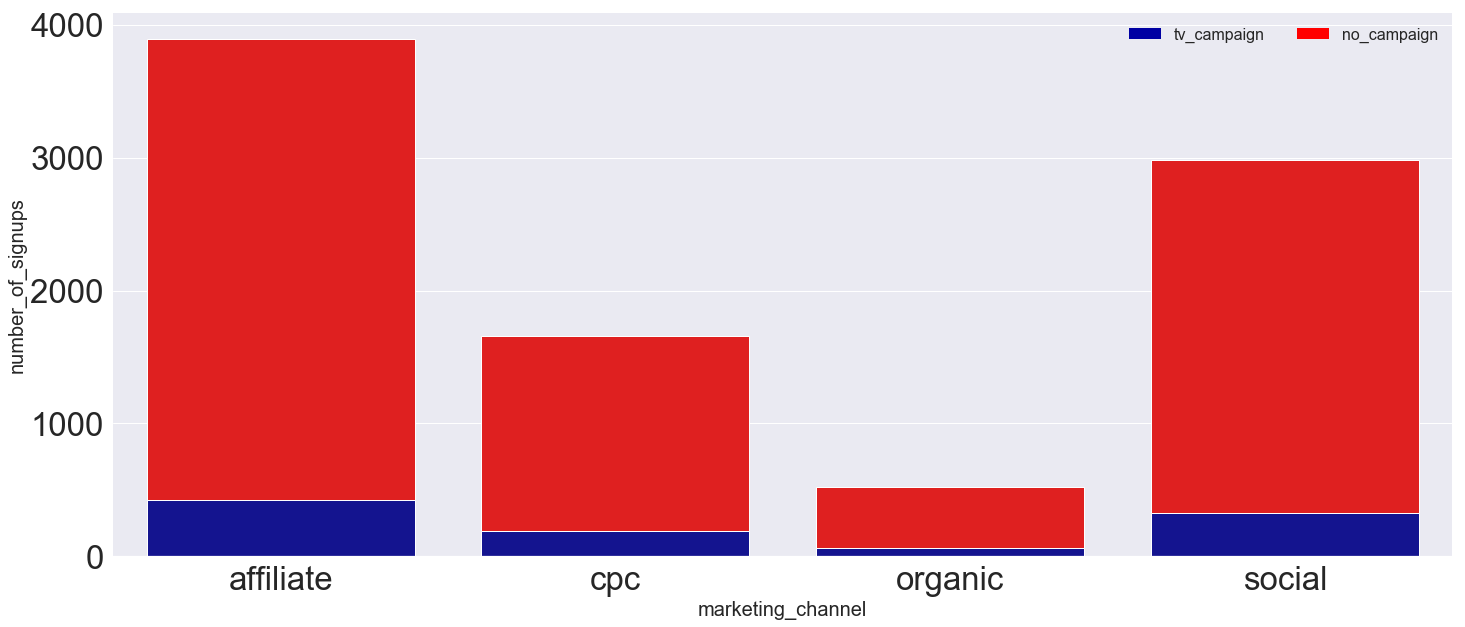

In [6]:
sns.set_context({"figure.figsize": (24, 10)})
sns.set(font_scale=3)

#Plot 1 - background - "total" series - this will be background and show the no_campaign part of total
sns.barplot(x = all_df['channel'], y = all_df['total'], color = "red")

#Plot 2 - overlay - "tv_campaign" series
bottom_plot = sns.barplot(x = all_df['channel'], y = all_df['tv_campaign'], color = "#0000A3")


topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['tv_campaign', 'no_campaign'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

sns.despine(left=True)
bottom_plot.set_ylabel("number_of_signups", fontsize = 20)
bottom_plot.set_xlabel("marketing_channel", fontsize = 20)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([736327., 736330., 736344., 736358., 736361., 736375., 736389.,
        736403., 736417., 736420.]), <a list of 10 Text xticklabel objects>)

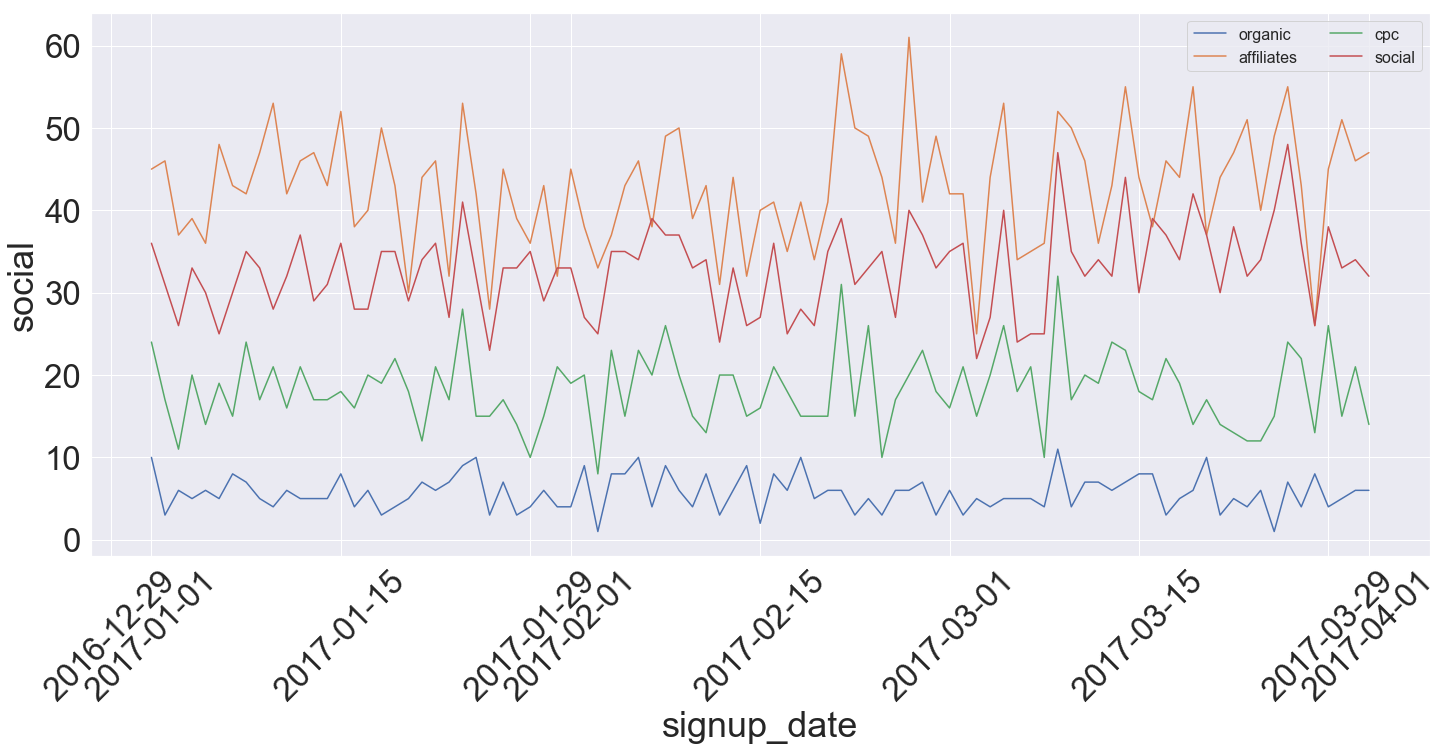

In [7]:
signups_by_day_df = merged.groupby(['signup_date', 'campaign']).agg({'cpc':'sum', 'affiliate':'sum', 'organic':'sum', 'social':'sum','userid':'count'}).reset_index()
signups_by_day_df = signups_by_day_df.rename({'userid': 'total_signups'}, axis=1)

for campaign in ['organic', 'affiliate', 'cpc', 'social']:
    ax = sns.lineplot(data=signups_by_day_df, x='signup_date', y=campaign)
plt.legend(['organic', 'affiliates', 'cpc', 'social'], loc=1, ncol = 2, prop={'size':16})
plt.xticks(rotation=45)

### Task 2. Estimate the impact of doubling TV spending

Assumptions:

- Assume the relationship between TV spending and user accquisition is linear and does not plateu
- Assume doubling the TV spend refers to doubling the TV spend means doubling the amount of days that ads run for
- Assume TV adverts have the same effect independent of the day they are aired on

Since we do not have data on abandoned journeys (i.e. journeys of people interacting with channels but not signing up), I don't think it is suitable to perform multivariate regression as we do not know accurately how much each channel contributes to user accquisition.

Results:

- The linear regression has a slope of 15.13, indicating 15 users per day. Since TV campaigns were run for 8 days in th year, this suggests that 121 users out of 5000 users signed up in the dates provided were accquired with TV campaigns. If the days that TV campains aired doubles to 16 days then we would expect to see an increase of another 120 sign ups, suggesting the number of total signups will increase to 5120 users.

,campaign,average_number_of_signups
0,0,53.614458
1,1,68.750000


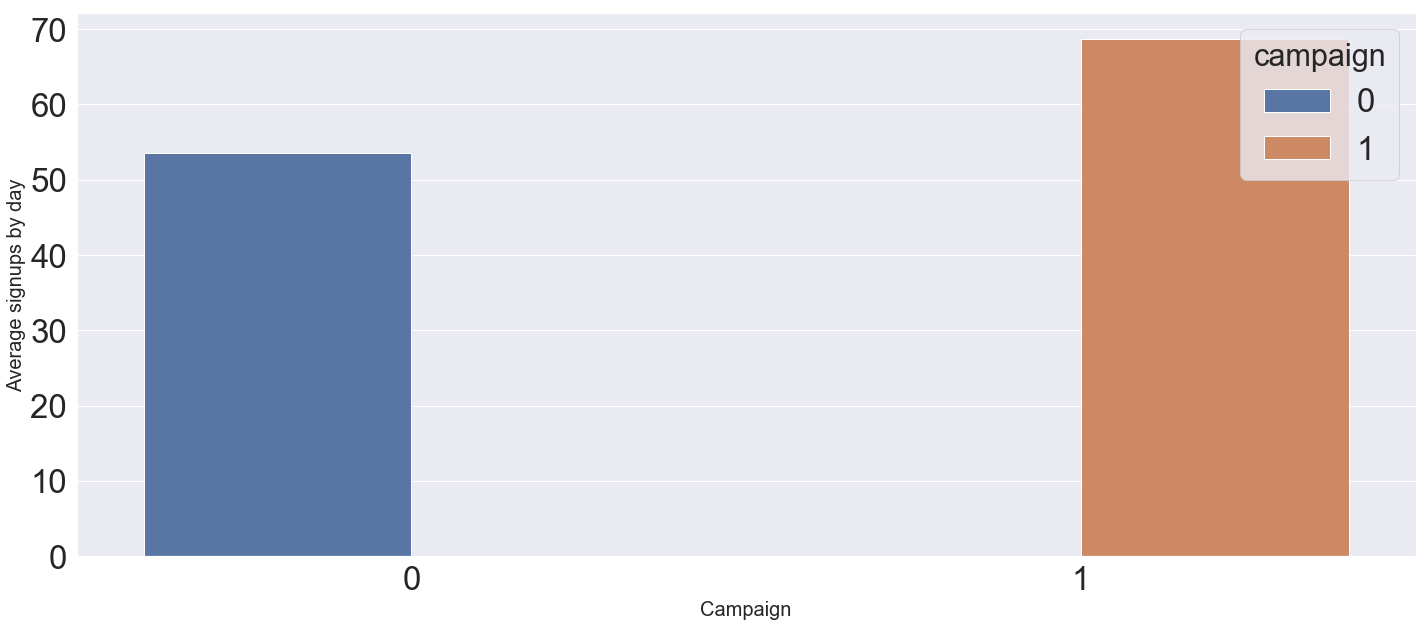

In [15]:
average_user_signup_by_campaign = signups_by_day_df.groupby('campaign')['total_signups'].mean().to_frame('average_number_of_signups').reset_index()
ax = sns.barplot(data=average_user_signup_by_campaign, hue='campaign', x='campaign', y='average_number_of_signups')
ax.set_xlabel('Campaign', fontsize = 20)
ax.set_ylabel('Average signups by day', fontsize = 20)

average_user_signup_by_campaign

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

y = np.array(signups_by_day_df['total_signups'])
X = np.array(signups_by_day_df['campaign'])

model = LinearRegression()

model.fit(X.reshape(-1,1), y)

#Retrieve the intercept:
print('model intercept: ', model.intercept_)

#Retrieve the slope:
print('model slope: ', model.coef_)

#Retrieve the r^2:
print('r^2: ', model.score(X.reshape(-1,1),y))

model intercept:  53.614457831325296
model slope:  [15.13554217]
r^2:  0.29856128709671115


Text(0, 0.5, 'Total signups by day')

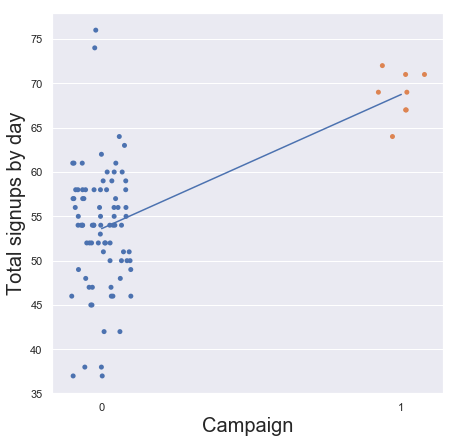

In [18]:
sns.set(font_scale=1)
x_fit = np.linspace(0,1)
y_fit = model.predict(x_fit[:, np.newaxis])


ax = sns.set_context({"figure.figsize": (7, 7)})
ax = sns.stripplot(data=signups_by_day_df, x='campaign', y='total_signups')
ax = sns.lineplot(x_fit, y_fit)
ax.set_xlabel('Campaign', fontsize = 20)
ax.set_ylabel('Total signups by day', fontsize = 20)

### Task 3: Make appropriate assumptions for the channel touchpoint cost. With your assumptions give recommendations how to change the budget allocation to maximize user acquisition with a constant budget

- see presentation